# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.  

**Цель**:   

Построение модели, которая по фотографии определит приблизительный возраст человека.  
В распоряжении имеется набор фотографий людей с указанием возраста.


**Задачи**:
- 1. Проведение исследовательского анализа набора фотографий.  
- 2. Подготовка данных к обучению.  
- 3. Обучение нейронной сети и рассчет её качества.

***Imports***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Исследовательский анализ данных

In [2]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
df_labels.shape

(7591, 2)

In [4]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Все верно, после загрузки датафрейма не забываем познакомиться с данными.</div>

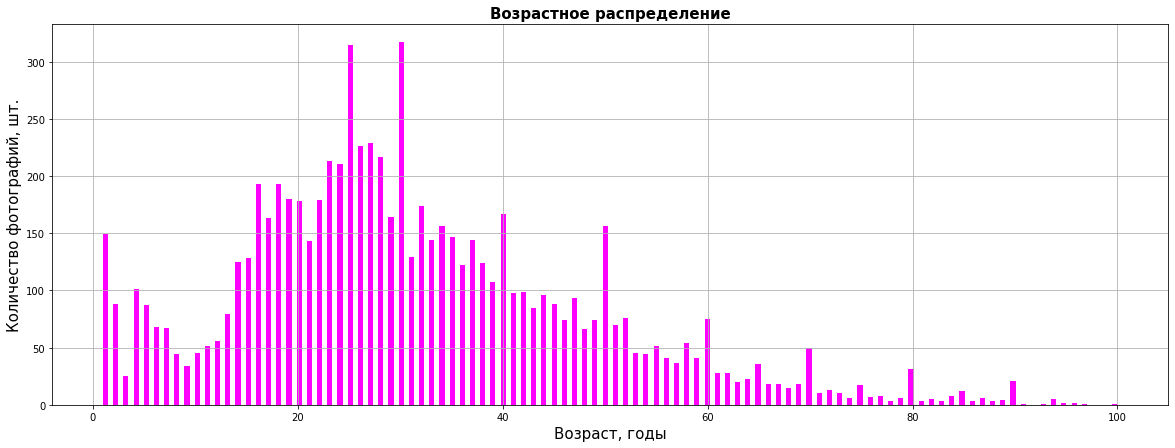

In [5]:
title = 'Возрастное распределение'
xlabel = 'Возраст, годы'
ylabel = 'Количество фотографий, шт.'
ax = df_labels['real_age'].plot(kind='hist', bins=199, grid=True, color='magenta', figsize=(20,7));
ax.set_xlabel(xlabel, fontsize=15);
ax.set_ylabel(ylabel, fontsize=15);
ax.set_title(title, fontsize=15, fontweight="bold");

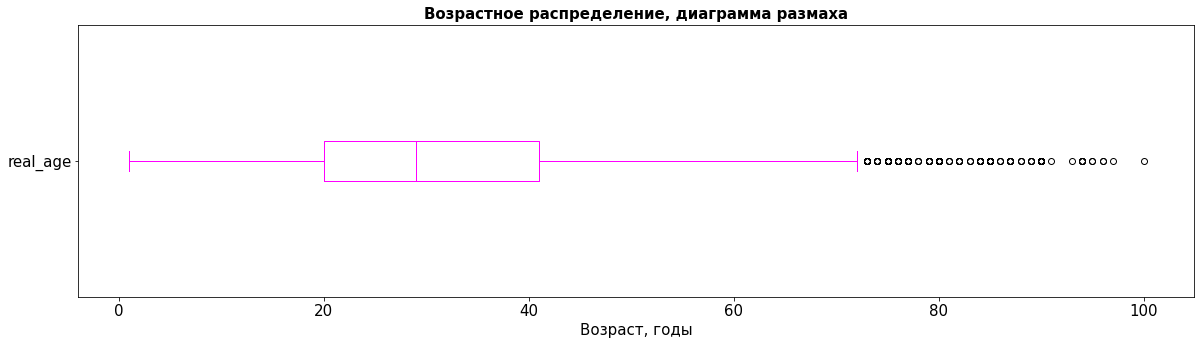

In [6]:
ax = df_labels.boxplot(column=['real_age'], vert=False, grid=False, fontsize=15, color='magenta', figsize=(20,5));
title = 'Возрастное распределение, диаграмма размаха'
xlabel = 'Возраст, годы'
ax.set_xlabel(xlabel, fontsize=15);
ax.set_title(title, fontsize=15, fontweight="bold");

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


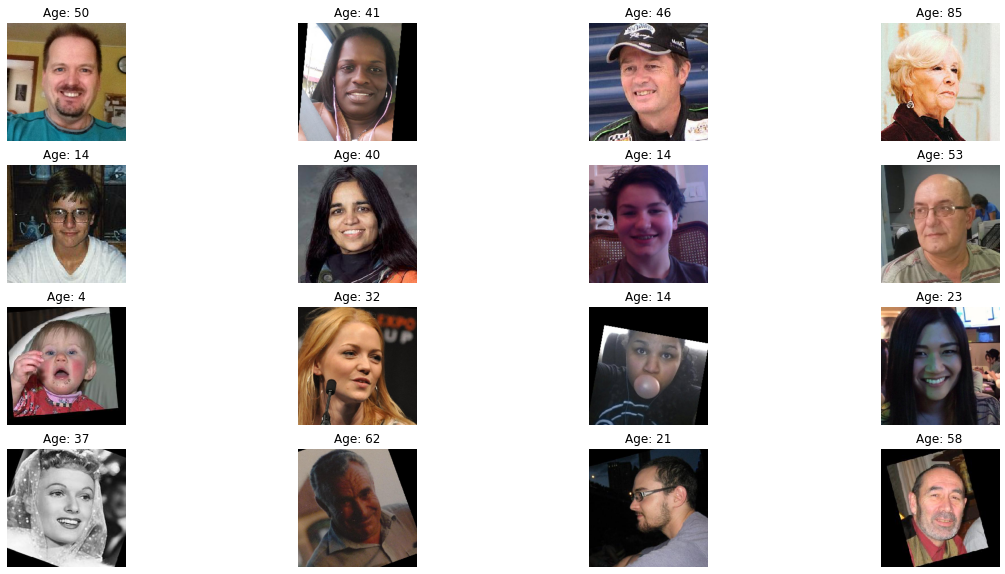

In [8]:
images, real_ages = next(train_gen_flow)

# Выводим первые 16 изображений

plt.figure(figsize=(20, 10))

for i in range(16):
    plt.subplot(4, 4, i+1) 
    plt.imshow(images[i])
    plt.title(f"Age: {int(real_ages[i])}")
    plt.axis('off')

plt.show()

**Выводы:**  
- в рассматриваемом датасете 7591 фотографий с информацией о возрасте;
- возрастной диапазон - от 1 до 100 лет, средний возраст составляет 31.2 года, медианный - 29 лет;
- 50% значений лежат в диапазоне от 20 до 41 лет;  

Пожалуй, можно сказать, что люди на фото соответствуют обозначенному возрасту.  
На лицах разная мимика, кто то в очках.  
Основной ракурс фото - анфас.

## Обучение модели

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Функции для создания датагенераторов (с аугментацией):

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       vertical_flip=True,
                                       rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                           directory=path + 'final_files/',
                                                           x_col='file_name',
                                                           y_col='real_age',
                                                           target_size=(224, 224),
                                                           batch_size=16,
                                                           class_mode='raw',
                                                           subset='training',
                                                           seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path + 'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=16,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=12345)

    return test_datagen_flow

# Функции для создания и обучения модели:

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=25,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Значения лосс-функции и метрики `MAE` по эпохам:

```
Epoch 1/25
2024-09-11 18:42:36.685242: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-09-11 18:42:37.226229: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 80s - loss: 254.8837 - mae: 11.6224 - val_loss: 416.8127 - val_mae: 15.4350
Epoch 2/25
356/356 - 78s - loss: 105.0602 - mae: 7.8036 - val_loss: 136.5321 - val_mae: 9.1554
Epoch 3/25
356/356 - 71s - loss: 74.8356 - mae: 6.5806 - val_loss: 85.6857 - val_mae: 7.0312
Epoch 4/25
356/356 - 62s - loss: 59.6643 - mae: 5.8554 - val_loss: 88.4946 - val_mae: 7.3314
Epoch 5/25
356/356 - 56s - loss: 43.6967 - mae: 5.1182 - val_loss: 88.9950 - val_mae: 7.0144
Epoch 6/25
356/356 - 54s - loss: 35.3899 - mae: 4.5254 - val_loss: 82.5465 - val_mae: 7.0356
Epoch 7/25
356/356 - 64s - loss: 28.9104 - mae: 4.1156 - val_loss: 116.9203 - val_mae: 8.5929
Epoch 8/25
356/356 - 65s - loss: 24.1171 - mae: 3.7095 - val_loss: 81.9311 - val_mae: 6.9908
Epoch 9/25
356/356 - 62s - loss: 18.8755 - mae: 3.3280 - val_loss: 85.6866 - val_mae: 6.8654
Epoch 10/25
356/356 - 55s - loss: 16.5310 - mae: 3.0980 - val_loss: 76.5064 - val_mae: 6.6277
Epoch 11/25
356/356 - 48s - loss: 15.3796 - mae: 2.9709 - val_loss: 73.9340 - val_mae: 6.5823
Epoch 12/25
356/356 - 46s - loss: 15.6364 - mae: 3.0254 - val_loss: 83.0264 - val_mae: 6.8529
Epoch 13/25
356/356 - 46s - loss: 15.1064 - mae: 2.9674 - val_loss: 74.0868 - val_mae: 6.4445
Epoch 14/25
356/356 - 60s - loss: 14.0501 - mae: 2.8360 - val_loss: 84.9829 - val_mae: 6.9703
Epoch 15/25
356/356 - 65s - loss: 13.8768 - mae: 2.8473 - val_loss: 71.9151 - val_mae: 6.4146
Epoch 16/25
356/356 - 64s - loss: 12.7557 - mae: 2.7321 - val_loss: 72.1429 - val_mae: 6.3959
Epoch 17/25
356/356 - 61s - loss: 12.8032 - mae: 2.7192 - val_loss: 74.1660 - val_mae: 6.6384
Epoch 18/25
356/356 - 53s - loss: 12.2535 - mae: 2.6740 - val_loss: 69.9708 - val_mae: 6.4106
Epoch 19/25
356/356 - 51s - loss: 11.1346 - mae: 2.5464 - val_loss: 70.9195 - val_mae: 6.2604
Epoch 20/25
356/356 - 51s - loss: 11.5545 - mae: 2.5727 - val_loss: 74.9743 - val_mae: 6.5988
Epoch 21/25
356/356 - 52s - loss: 10.4101 - mae: 2.4793 - val_loss: 69.5397 - val_mae: 6.3085
Epoch 22/25
356/356 - 50s - loss: 9.9792 - mae: 2.3945 - val_loss: 78.5479 - val_mae: 6.4535
Epoch 23/25
356/356 - 54s - loss: 9.2401 - mae: 2.3171 - val_loss: 68.8546 - val_mae: 6.2885
Epoch 24/25
356/356 - 75s - loss: 10.3570 - mae: 2.4346 - val_loss: 70.3323 - val_mae: 6.3027
Epoch 25/25
356/356 - 63s - loss: 10.0170 - mae: 2.4118 - val_loss: 69.5744 - val_mae: 6.2687

```

## Анализ обученной модели

Для обучения использована модель ResNet50 с оптимозаторм Adam (learning_rate=0.0001).  
В результате теста на 25 эпохах получено стабильный диапазон значений метрики MAE: 6.26-6.99, что соответствует условию задания (MAE<8).  
Таким образом, погрешность определения возраста составляет 6-7 лет, что позволяет классифицировать покупателей по возрастным группам с целью анализа покупок и предложения товаров.  
При определенных обстоятельствах модель поможет контролировать добросовестность кассиров при продаже алкоголя.